In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrainedModel = '.datasets/lenet_mnist_model.pth'
useCuda = False

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
testLoader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets', train=False, download=True, transform = transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=1, shuffle=True
)

0it [00:00, ?it/s]

100%|█████████▉| 9879552/9912422 [00:20<00:00, 427430.06it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 144767.37it/s]
32768it [00:00, 95728.31it/s]                            
0it [00:00, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz



 95%|█████████▍| 1564672/1648877 [00:03<00:00, 784344.93it/s]
1654784it [00:04, 412604.34it/s]                             
0it [00:00, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 31253.20it/s]            

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [8]:
device = torch.device("cuda" if (useCuda and torch.cuda.is_available()) else "cpu")

In [9]:
# Initialize the network
model = Net().to(device)

In [10]:
# Load the pretrained model
model.load_state_dict(torch.load(pretrainedModel, map_location='cpu'))

In [11]:
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

In [12]:
# FGSM attack code

In [13]:
def fgsmAttack(image, epsilon, dataGrad):
    # Collect the element-wise sign of the data gradient
    signDataGrad = dataGrad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbedImage = image + epsilon * signDataGrad
    # Adding clipping to maintain [0,1] range
    perturbedImage = torch.clamp(perturbedImage, 0, 1)
    return perturbedImage

### Testing function

In [16]:
def test(model, device, testLoader, epsilon):
    #Accuracy counter
    correct = 0
    advExamples = []
    
    #Loop over all the exmaples in test set
    for data, target in testLoader:
        
        data, target = data.to(device), target.to(device)
        
        #Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        #Forward pass the data through the model
        output = model(data)
        initPred = output.max(1, keepdim=True)[1] #get the index of the max log-probability
        
        #If the initPred is wrong, dont bother attacking
        if initPred.item() != target.item():
            continue
            
        loss = F.nll_loss(output, target)
        
        model.zero_grad()
        
        loss.backward()
        
        #Collect datagrad
        dataGrad = data.grad.data
        
        #Call FGSM Attack
        perturbedData = fgsmAttack(data, epsilon, dataGrad)
        
        # Re-classify the perturbed image
        output = model(perturbedData)
        
        # Check for success
        finalPred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        if finalPred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(advExamples) < 5):
                advEx = perturbedData.squeeze().detach().cpu().numpy()
                advExamples.append( (initPred.item(), finalPred.item(), advEx) )
            else:
                # Save some adv examples for visualization later
                if len(advExamples) < 5:
                    advEx = perturbedData.squeeze().detach().cpu().numpy()
                    advExamples.append( (initPred.item(), finalPred.item(), advEx) )
                    
    # Calculate final accuracy for this epsilon
    finalAcc = correct/float(len(testLoader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(testLoader), finalAcc))

    # Return the accuracy and an adversarial example
    return finalAcc, advExamples

### Run Attack

In [17]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testLoader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


### Results

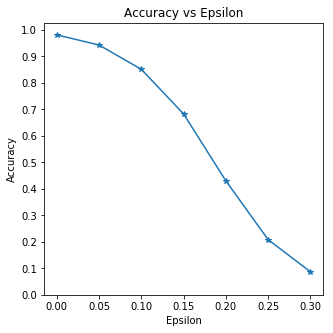

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

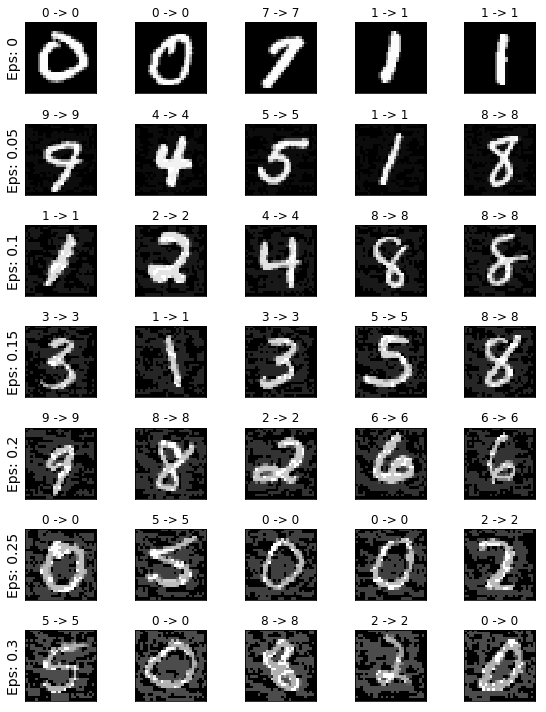

In [19]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()